Dirichlet Processes: A simulated guide

(transformed from https://ericmjl.github.io/dl-workshop/04-gaussian-clustering/02-dirichlet-processes.html )

In [6]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import vmap, random, lax
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from dp_mixgauss_truncated import stick_breaking_weights, beta_draw_from_weights, component_probs_loglike

The stick-breaking definition of Dirichlet process (DP)
\begin{align*}
G &= \sum_{i=1}^{\infty} \pi_i \delta_{\theta_i} \\
\pi_i &= \beta_i\prod_{j=1}^{i-1}(1-\beta_i) \\
\beta_i &\overset{i.i.d.}{\sim} \text{Beta}(1, \alpha) 
\end{align*}

Visualizing the stick-breaking construction of a DP:

Text(0, 0.5, 'Weight of a single item')

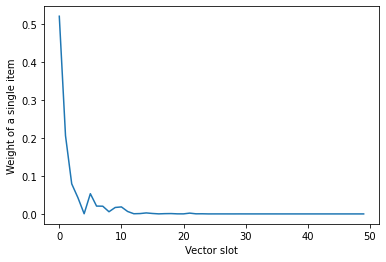

In [7]:
def dp_draw(key, concentration, vector_length):
    # Draw a sample from DP using the stick-breaking approach, alpha=concentration
    # and cut at vector_length.
    beta_draws = random.beta(key=key, a=1, b=concentration, shape=(vector_length,))
    occupied_probability, weights = stick_breaking_weights(beta_draws)
    return occupied_probability, weights


key = random.PRNGKey(42)
occupied_probability, weights = dp_draw(key, 3, 50)
plt.plot(weights)
plt.xlabel("Vector slot")
plt.ylabel("Weight of a single item")

<AxesSubplot:>

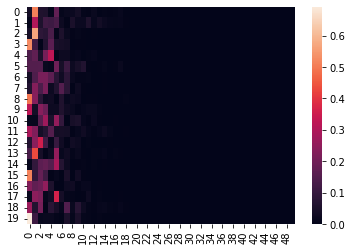

In [8]:
# Multiple samples from DP
keys = random.split(key, 20)
occupied_probabilities, weights_draws = vmap(partial(dp_draw, concentration=3, vector_length=50))(keys)
sns.heatmap(weights_draws)

As is visible above, when concentration parameter = 3, most of the probability mass is concentrated across rouighly the first 5-8 states.

We explore the effect of the concentration parameter on DP by plotting samples from DPs with differerent values of the concentration paramter.

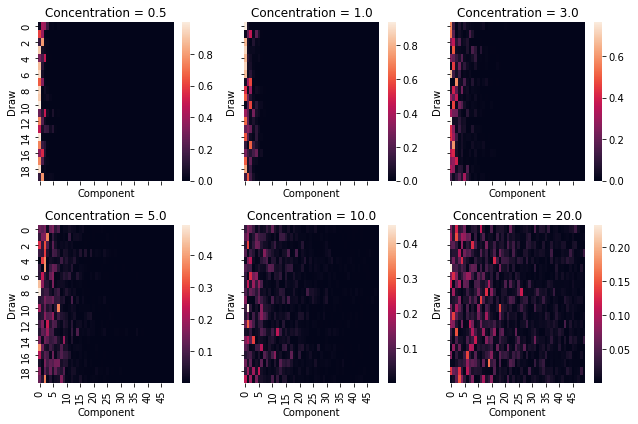

In [9]:
def dirichlet_one_concentration(key, concentration, num_draws):
    keys = random.split(key, num_draws)
    occupied_probabilities, weights_draws = vmap(partial(dp_draw, concentration=concentration, vector_length=50))(keys)
    return occupied_probabilities, weights_draws


concentrations = jnp.array([0.5, 1, 3, 5, 10, 20])
keys = random.split(key, len(concentrations))
occupied_probabilites, weights_draws = vmap(partial(dirichlet_one_concentration, num_draws=20))(keys, concentrations)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(3 * 3, 3 * 2), sharex=True, sharey=True)
for ax, weights_mat, conc in zip(axes.flatten(), weights_draws, concentrations):
    sns.heatmap(weights_mat, ax=ax)
    ax.set_title(f"Concentration = {conc}")
    ax.set_xlabel("Component")
    ax.set_ylabel("Draw")
plt.tight_layout()

As the concentration parameter increases, the random probability measure sampled from DP becomes less concentrated, which means:
1. The probability mass allocated to the components that have significant probability mass decreases;
2. More components have "significant" amounts of probability mass allocated.

Under the stick-breaking construction, we can evaluate the likelihood of the simulated DP sample under the beta distribution. 
The first step is to reverse the stick-breaking construction and obtain the beta-distributed variables from the DP sample.

Text(0, 0.5, 'Beta Draw')

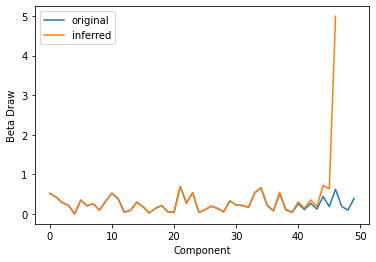

In [10]:
concentration = 3
beta_draws = random.beta(key=key, a=1, b=concentration, shape=(50,))
occupied_probability, weights = stick_breaking_weights(beta_draws)
final, beta_hat = beta_draw_from_weights(weights)

plt.plot(beta_draws, label="original")
plt.plot(beta_hat, label="inferred")
plt.legend()
plt.xlabel("Component")
plt.ylabel("Beta Draw")

Text(0, 0.5, 'Log likelihood')

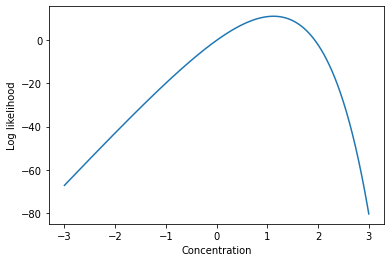

In [11]:
# Plotting the log-likelihood.
log_concentration = jnp.linspace(-3, 3, 1000)


def make_vmappable_loglike(log_component_probs, num_components):
    def inner(log_concentration):
        return component_probs_loglike(log_component_probs, log_concentration, num_components)

    return inner


component_probs_loglike_vmappable = make_vmappable_loglike(log_component_probs=jnp.log(weights), num_components=25)

lls = vmap(component_probs_loglike_vmappable)(log_concentration)
plt.plot(log_concentration, lls)
plt.xlabel("Concentration")
plt.ylabel("Log likelihood")

Given the likelihood function, we can obtain the maximum likelihood estimate (MLE) of the concentration parameter of the DP. If we define the loss function of the concentration parameter to be the negative of its likelihood, to maximize the likelihood is equivalent to minimize the loss function.

With Jax, it is straightforward to take the gradient descent approach in search for the MLE, where we can use 'grad' function to compute the gradient automatically.

In [12]:
# Defining the loss function
def make_loss_dp(num_components):
    def loss_dp(log_concentration, log_component_probs):
        """
        Log-likelihood of component_probabilities of Dirichlet process.
        :param log_concentration: Scalar value.
        :param log_component_probs: One or more component probability vectors.
        """
        vm_func = partial(component_probs_loglike, log_concentration=log_concentration, num_components=num_components)
        ll = vmap(vm_func, in_axes=0)(log_component_probs)
        return -jnp.sum(ll)

    return loss_dp

In [13]:
# Defining the gradient descent loop
def fit(loss, optimizer, data, initial_params, T=1000):
    def step(carry, _):
        params, opt_state = carry
        loss_value, grads = jax.value_and_grad(loss)(params, data)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss_value

    carry = (initial_params, optimizer.init(initial_params))
    final_params, loss_history = lax.scan(step, carry, xs=None, length=T)
    return final_params, loss_history

In [14]:
# Initialization
loss = make_loss_dp(num_components=25)
optimizer = optax.adam(learning_rate=0.05)
log_concentration_init = random.normal(key, (1,))
initial_params = jnp.array([log_concentration_init])
data = jnp.log(weights_draws[3] + 1e-6)

In [15]:
# Model fitting
(final_params, final_state), loss_history = fit(loss, optimizer, data, initial_params)

/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


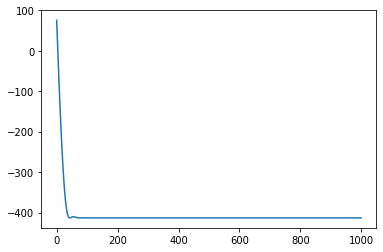

In [16]:
plt.plot(loss_history)

In [17]:
# The MLE
jnp.exp(final_params)

DeviceArray([[5.10591]], dtype=float32)